# Import Libraries

In [1]:
import pandas as pd
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
from tensorflow.keras.layers import Flatten, LSTM, Dropout, Bidirectional, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Conv2DTranspose, BatchNormalization, Activation, ConvLSTM2D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle

import cv2

# Classification Model

In [2]:
def my_categorical_weighted_loss(labels, logits):
    """scale loss based on class weights
    """
    # reshape 
    labels = tf.reshape(labels, [-1,2])
    logits = tf.reshape(logits, [-1,2])
    # compute weights based on their frequencies (higher weight to less frequent classes)
    class_weights = [5., 3.]
    # compute weights based on labels
    labels = tf.cast(labels, tf.float32)
    weights = labels * class_weights
    weights = tf.reduce_sum(weights, axis=1)
    
    weights = tf.reshape(weights, [-1])
    
    
    # compute (unweighted) softmax cross entropy loss
    unweighted_losses = tf.keras.losses.categorical_crossentropy(labels, logits)
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    return loss

In [3]:
# https://keras.io/examples/vision/3D_image_classification/
num_frames = 32
from tensorflow.keras import layers
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, width, height, 3))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

    # changed units from 512 to 256 temporarily, since I commented the previous layers
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # because 2 classes? change from sigmoid to softmax?
    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    cnn_model = keras.Model(inputs, outputs, name="3dcnn")
    return cnn_model


# Build model.
# depth is # of frames?
cnn_model = get_model(width=112, height=112, depth=num_frames)
cnn_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 112, 112, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 30, 110, 110, 64)  5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 55, 55, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 53, 53, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 26, 26, 128)   0         
 3D)                                                             
                                                             

In [4]:
# cnn_model.compile(loss="categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(),
#     metrics=["acc"],)
cnn_model.compile(loss=my_categorical_weighted_loss,
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"],)

In [5]:
cnn_model.load_weights('3dcnn_2class.h5')

In [6]:
with open('class_train_gpu.npy', 'rb') as f:
    colored_train_frames_normalized = np.load(f)
    train_labels = np.load(f)
with open('class_val_gpu.npy', 'rb') as f:
    colored_val_frames_normalized = np.load(f)
    val_labels = np.load(f)
with open('class_test_gpu.npy', 'rb') as f:
    colored_test_frames_normalized = np.load(f)
    test_labels = np.load(f)

In [7]:
batch_size=1
cnn_model.fit(colored_train_frames_normalized, train_labels, batch_size=batch_size, epochs=5, 
              validation_data=(colored_val_frames_normalized, val_labels), validation_batch_size=batch_size)

Epoch 1/5
250/250 [==============================] - 30s 113ms/step - loss: 2.5230 - acc: 0.6320 - val_loss: 2.3898 - val_acc: 0.6800 - loss: 2.6690 - acc: 0.67 - ETA - ETA: 16s - loss: 2.6754 - - ETA: 16s - loss: 2.68 - ETA: 15s - loss: 2.6630 - acc:  - ETA: 15s - lo - - ETA: 12s - loss: 2.6311 - acc:  - ETA: 11s - loss: 2.6189 - acc - ETA: 11s - loss: 2.6104 - - ETA: 10s - loss: 2.6133 - - ETA: 10s - loss: 2.5854 - acc - ETA: 9s - loss: 2.5978 - acc: 0.602 - ETA: 9s - loss: 2.5931 - acc: 0.605 - ETA: 9s - loss: 2.5858 - a - ETA: 8s - loss: 2.5701 - acc: - ETA: 7s - loss: 2.5827 - ETA: 6s - loss: 2.5822 - acc:  - ETA: 5s - loss: 2.5746 - acc: 0. - ETA: 5s - loss: 2.5782 - ETA: 4s - loss: 2.5726 - acc: 0.
Epoch 2/5
250/250 [==============================] - 28s 111ms/step - loss: 2.4942 - acc: 0.6440 - val_loss: 2.3913 - val_acc: 0.6800 2. - ETA: 11s - loss: 2.5492 -  - ETA: 8s - loss: 2.5255 - acc:  - ETA: 8s - loss: 2.5364 - acc - ETA: 7s - loss: 2.53 - ETA: 5s - loss: 2.5048 - - ETA

# Results

In [8]:
colored_test_frames_normalized

array([[[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         ...,

         [[0.        , 0.        , 0.        ],
          [0.        ,

In [9]:
test_preds = cnn_model.predict(colored_test_frames_normalized, batch_size=1)

In [10]:
test_class_labels = np.argmax(test_labels,axis=1)
test_class_preds = np.argmax(test_preds, axis=1)

In [11]:
test_class_labels.mean()

0.74

In [12]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_class_labels, test_class_preds)

<AxesSubplot:>

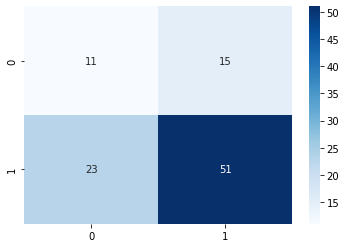

In [13]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

In [14]:
test_preds

array([[0.38163036, 0.61836964],
       [0.51329476, 0.48670527],
       [0.6242042 , 0.37579578],
       [0.44645548, 0.5535445 ],
       [0.40962848, 0.59037155],
       [0.40429896, 0.59570104],
       [0.30830532, 0.6916947 ],
       [0.37454784, 0.62545216],
       [0.6453956 , 0.3546044 ],
       [0.47372243, 0.5262776 ],
       [0.54251724, 0.45748278],
       [0.62448174, 0.37551823],
       [0.3980863 , 0.60191363],
       [0.6467946 , 0.3532054 ],
       [0.4243501 , 0.5756499 ],
       [0.6569921 , 0.34300795],
       [0.42741117, 0.5725888 ],
       [0.383932  , 0.61606807],
       [0.45538613, 0.5446139 ],
       [0.50656086, 0.49343917],
       [0.485412  , 0.514588  ],
       [0.42242312, 0.57757694],
       [0.5291637 , 0.47083625],
       [0.4074895 , 0.59251046],
       [0.3587074 , 0.6412926 ],
       [0.5625508 , 0.43744916],
       [0.43525967, 0.56474036],
       [0.44702908, 0.5529709 ],
       [0.3962025 , 0.6037975 ],
       [0.44476783, 0.5552321 ],
       [0.

In [15]:
accuracy = sum(test_class_labels == test_class_preds)/len(test_class_labels)
accuracy

0.62

In [16]:
from sklearn.metrics import classification_report
target_names = ["Abnormal EF", "Normal EF"]
print("sklearn classification report: \n" + classification_report(test_class_labels, test_class_preds, target_names=target_names))

sklearn classification report: 
              precision    recall  f1-score   support

 Abnormal EF       0.32      0.42      0.37        26
   Normal EF       0.77      0.69      0.73        74

    accuracy                           0.62       100
   macro avg       0.55      0.56      0.55       100
weighted avg       0.66      0.62      0.63       100



In [18]:
# cnn_model.save('3dcnn_2class.h5')